Demonstrate how LTP-IE can be used to store and decode paired associations.

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

from aux import sgmd
from disp import set_font_size, set_n_x_ticks, set_n_y_ticks
from assoc import plot, smln


# model params
M = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 4000,
    'W_PC_PC': 0.034, 'L_PC_PC': 0.0835, 'W_MIN_PC_PC': 0.001,
    
    # "Place-tuned" PC inputs
    'R_MAX': 20, 'L_PL': .15,
    'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.009, 'E_L_INH': -0.058, 'V_TH_INH': -0.036, 'V_R_INH': -0.058, 'T_R_INH': 0.002,  # unused (presently)
    
    # Inh. architecture
    'N_INH': 100,  # unused
    
    # gating inputs
    'W_PC_G': 0.008216, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.005, 
    
    # Gating input firing rates for traj and replay epochs
    'R_G': 105, 
    
    # potentiation
    'SGM_MAX': 2, 'B_SGM': 1, 'R_SGM': 10
}

# smln params
S = {
    "RNG_SEED": 0,
    "DT": 0.0005, "BOX_H": 4, "BOX_W": 4,
    
    'SPD': 0.2,
    
    'CNTRS': {
        'S1': [(-.75, .75), 'r'],
        'S2': [(-.75, -.75), 'b'],
        'M1': [(.75, .75), 'c'],
        'M2': [(.75, -.75), 'm'],
    },
    
    'R_CNTR': 0.25,
    
    'TRG': [
        {'T': 0.2, 'A': 0.007, 'R': 0.3, 'D': 0.003, 'X': -.75, 'Y': .75},
        {'T': 0.7, 'A': 0.007, 'R': 0.3, 'D': 0.003, 'X': -.75, 'Y': -.75},
        
        {'T': 1.2, 'A': 0.007, 'R': 0.3, 'D': 0.003, 'X': -.75, 'Y': .75},
        {'T': 1.7, 'A': 0.007, 'R': 0.3, 'D': 0.003, 'X': -.75, 'Y': -.75},
        
        {'T': 2.2, 'A': 0.007, 'R': 0.3, 'D': 0.003, 'X': -.75, 'Y': .75},
        {'T': 2.7, 'A': 0.007, 'R': 0.3, 'D': 0.003, 'X': -.75, 'Y': -.75},
    ],
    
    'TRJ_SETS': [
        # 1
        [[(-.75, .75), (.75, .75)], [(-.75, -.75), (.75, -.75)]],

        # 2A
        [
            [(-.75, .75), (.75, -.75)],
            [(-.75, -.75), (-.75, -1.75), (1.75, -1.75), (1.75, .75), (.75, .75)],
        ],

        # 2B
        [
            [(-.75, .75), (.75, -.75)],
            [(-.75, -.75), (-1.75, -.75), (-1.75, 1.75), (.75, 1.75), (.75, .75)],
        ],

        # 2C
        [
            [(-.75, .75), (-.75, 1.75), (1.75, 1.75), (1.75, -.75), (.75, -.75)],
            [(-.75, -.75), (.75, .75)],
        ],
    ],
    
    "schedule": {"D_SMLN": 3},
    
    "metrics": {
        "WDW": 0.3, "MIN_SCALE_TRJ": 1.25,
        "MIN_FRAC_SPK_TRJ": 0.75, "MAX_AVG_SPK_CT_TRJ": 3, "TRJ_NON_TRJ_SPK_RATIO": 1.5,
    }
}

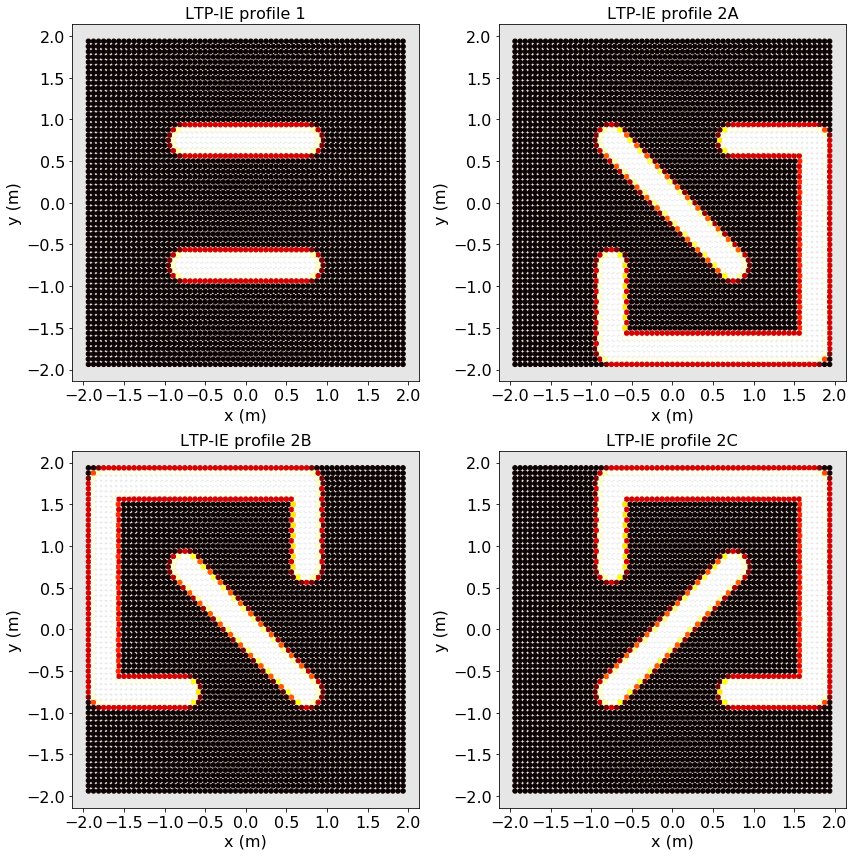

In [2]:
# show multi-trj veil construction function
s = copy(S)
s['RNG_SEED'] = 0

ntwks = []

for trjs in s['TRJ_SETS']:
    s['TRJ'] = trjs
    ## build trajectory
    trj = smln.build_trjs(s)
    schedule = s['schedule']

    ## adjust schedule
    t = np.arange(0, schedule['D_SMLN'], s['DT'])

    ## build ntwk
    ntwk = smln.build_ntwk(M, s)

    ## get apx. real-valued mask ("veil") over trj nrns;
    ## values are >= 0 and correspond to apx. scale factors on
    ## corresponding G->PC weights minus 1
    trj_veil = smln.get_trj_veil(trj, ntwk, M, s)
    ntwk.sgm = trj_veil + 1
    
    ntwk = smln.apx_ws_up(ntwk, trj_veil)
    
    ntwks.append(ntwk)

# show veil
fig, axs = plt.subplots(2, 2, figsize=(12, 12), tight_layout=True)
titles = ['LTP-IE profile {}'.format(l) for l in ['1', '2A', '2B', '2C']]


for ax, ntwk, title in zip(axs.flatten(), ntwks, titles):
    mask_pc = ntwk.types_rcr == 'PC'
    
    ax.scatter(ntwk.pfxs[mask_pc], ntwk.pfys[mask_pc], c=ntwk.sgm[mask_pc], cmap='hot', s=20)
    ax.set_facecolor((.9, .9, .9))

    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_title(title)

    set_font_size(ax, 16)

# Color key

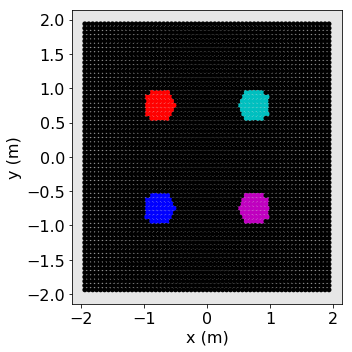

In [3]:
ntwk = smln.build_ntwk(M, S)
mask_pc = ntwk.types_rcr == 'PC'

# assign colors
cs = np.repeat('k', M['N_PC'])

for k, ((x, y), c) in S['CNTRS'].items():
    # make mask
    dx = ntwk.pfxs[mask_pc] - x
    dy = ntwk.pfys[mask_pc] - y
    d = np.sqrt(dx**2 + dy**2)
    mask = d <= S['R_CNTR']
    
    cs[mask] = c

fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)
ax.scatter(ntwk.pfxs[mask_pc], ntwk.pfys[mask_pc], c=cs, s=25, lw=0)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_facecolor((.9, .9, .9))

set_font_size(ax, 16)

del ntwk

# Simulations

In [4]:
t = np.arange(0, S['schedule']['D_SMLN'], S['DT'])

# build bgkd stim
np.random.seed(S['RNG_SEED'])

# make upstream gating spks array
spks_up = np.random.poisson(M['R_G']*S['DT'], (len(t), M['N_PC']))

# make trigger currents
i_trg = smln.i_ext_trg(t, ntwks[0], M, S, None)

In [5]:
# loop over ntwks
rslts = []

for n_ctr, ntwk in enumerate(ntwks):
    print('Running smln for ntwk {}/{}...'.format(n_ctr+1, len(ntwks)))
    rslt = ntwk.run(spks_up, S['DT'], i_ext=i_trg, report_every=10)
    
    # compute results to plot
    out = {}
    
    for k, ((x, y), c) in S['CNTRS'].items():
        # get mask over cells to measure
        mask_pc = ntwk.types_rcr == 'PC'
        dx = ntwk.pfxs - x
        dy = ntwk.pfys - y
        d = np.sqrt(dx**2 + dy**2)
        
        mask = mask_pc & (d <= S['R_CNTR'])
        
        # get all spks for this mask
        spks = rslt.spks[:, mask]
        
        # average spks across neurons
        out_ = spks.mean(axis=1)
        if out_.max() > 0:
            out_ /= out_.max()
            
        out[k] = out_
        
    rslt.out = out
    rslt.ntwk = ntwk
    
    rslts.append(rslt)

Running smln for ntwk 1/4...
Running smln for ntwk 2/4...
Running smln for ntwk 3/4...
Running smln for ntwk 4/4...


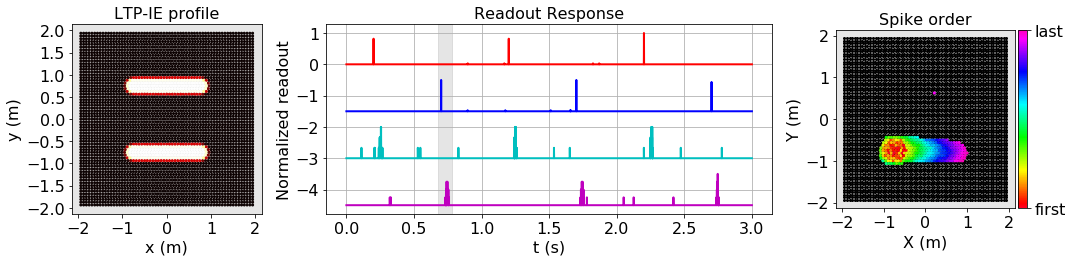

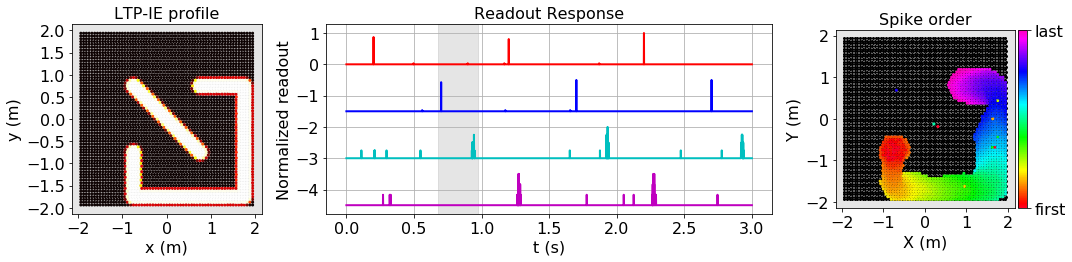

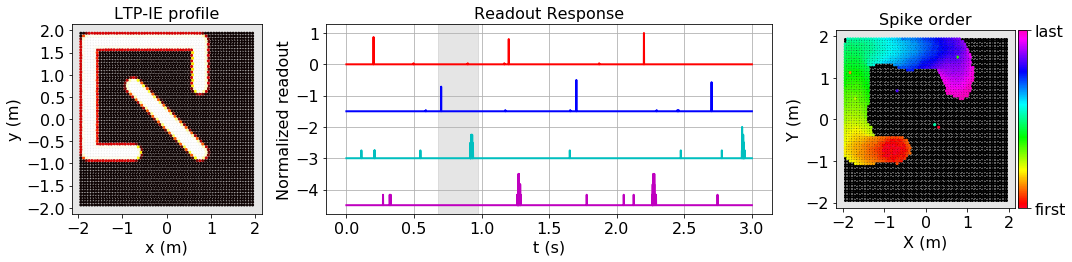

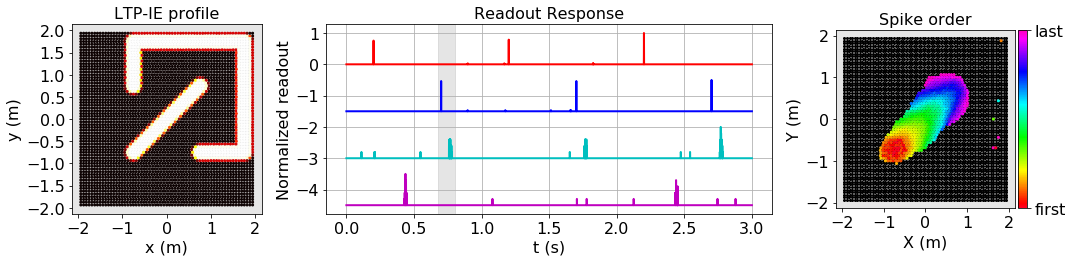

In [6]:
# plot results
sct_sz = 4
cmap = 'gist_rainbow'
shades = [(.68, .78), (.68, .97), (.68, .97), (.68, .8)]

for title, rslt, shade in zip(titles, rslts, shades):
    # get ntwk
    ntwk = rslt.ntwk
    mask_pc = ntwk.types_rcr == 'PC'
    pfxs_pc = ntwk.pfxs[mask_pc]
    pfys_pc = ntwk.pfys[mask_pc]
    
    # make plots
    gs = gridspec.GridSpec(1, 4)
    fig = plt.figure(figsize=(15, 15/4), tight_layout=True)
    
    ## LTP-IE profile
    axs = [fig.add_subplot(gs[0, 0])]
    
    axs[0].scatter(
        ntwk.pfxs[mask_pc], ntwk.pfys[mask_pc], c=ntwk.sgm[mask_pc], vmin=1, vmax=2, cmap='hot', s=sct_sz)
    axs[0].set_facecolor((.9, .9, .9))
    
    axs[0].set_aspect('equal')
    axs[0].set_xlabel('x (m)')
    axs[0].set_ylabel('y (m)')
    axs[0].set_title('LTP-IE profile')

    set_font_size(axs[0], 16)
    
    axs.append(fig.add_subplot(gs[0, 1:-1]))
    
    ## readout traces
    order = ['S1', 'S2', 'M1', 'M2']
    
    for ctr, k in enumerate(order):
        out_ = rslt.out[k]
        c = S['CNTRS'][k][1]
        offset = ctr * 1.5
        axs[-1].plot(rslt.ts, out_ - offset, color=c, lw=2)
        
    axs[-1].axvspan(*shade, color='gray', alpha=.2)
    
    axs[-1].set_xlabel('t (s)')
    axs[-1].set_ylabel('Normalized readout')
    
    axs[-1].set_title('Readout Response')
    
    axs[-1].grid()
    
    set_font_size(axs[-1], 16)
    
    ## spk orders for selected replay epoch
    axs.append(fig.add_subplot(gs[0, -1]))
    
    start, end = shade
    
    t_mask = (start <= rslt.ts) & (rslt.ts < end)
        
    spks_wdw_pc = rslt.spks[t_mask][:, mask_pc]
    spk_ct_wdw_pc = spks_wdw_pc.sum(0)
    
    ## black bkgd for all PCs
    axs[-1].scatter(pfxs_pc, pfys_pc, c='k', s=sct_sz, zorder=-1)

    ## color PCs according to timing of first spike
    spk_mask = spk_ct_wdw_pc > 0
    spk_order = np.argmax(spks_wdw_pc[:, spk_mask], 0)
    spk_order = np.argsort(spk_order).argsort()

    v_min = spk_order.min()
    v_max = spk_order.max()

    im = axs[-1].scatter(
        pfxs_pc[spk_mask], pfys_pc[spk_mask], c=spk_order, s=sct_sz,
        vmin=v_min, vmax=v_max, cmap=cmap, zorder=0)

    divider = make_axes_locatable(axs[-1])
    c_ax = divider.append_axes('right', size='5%', pad=0.05)

    cb = fig.colorbar(im, cax=c_ax, ticks=[v_min, v_max])
    cb.set_ticklabels(['first', 'last'])

    axs[-1].set_aspect('equal')

    set_n_x_ticks(axs[-1], 5, -S['BOX_W']/2, S['BOX_W']/2)
    set_n_y_ticks(axs[-1], 5, -S['BOX_H']/2, S['BOX_H']/2)

    axs[-1].set_facecolor((.9, .9, .9))
    
    axs[-1].set_aspect('equal')
    
    axs[-1].set_xlabel('X (m)')
    axs[-1].set_ylabel('Y (m)')
    
    axs[-1].set_title('Spike order')
    
    for ax_ in [axs[-1], cb.ax]:
        set_font_size(ax_, 16)

### Plot all replay epochs

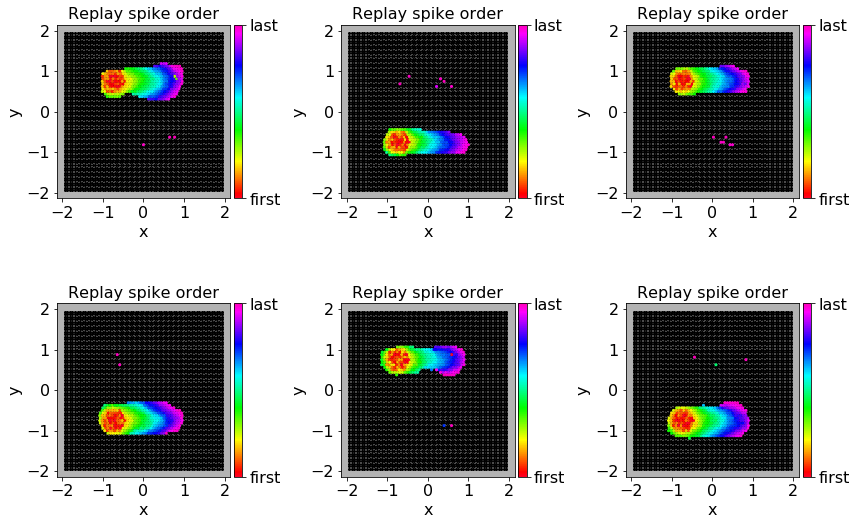

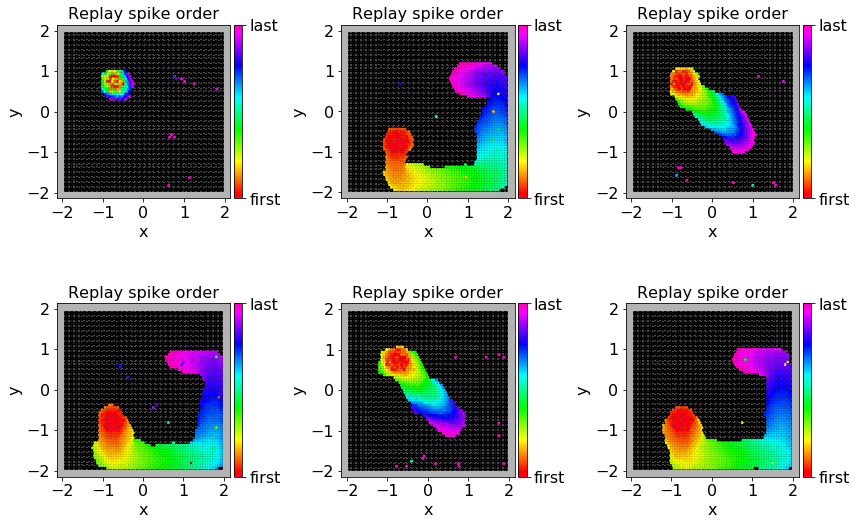

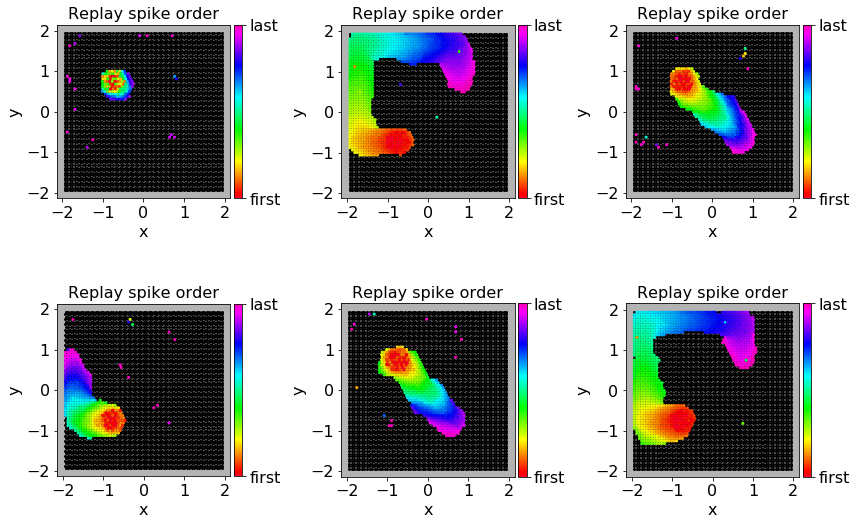

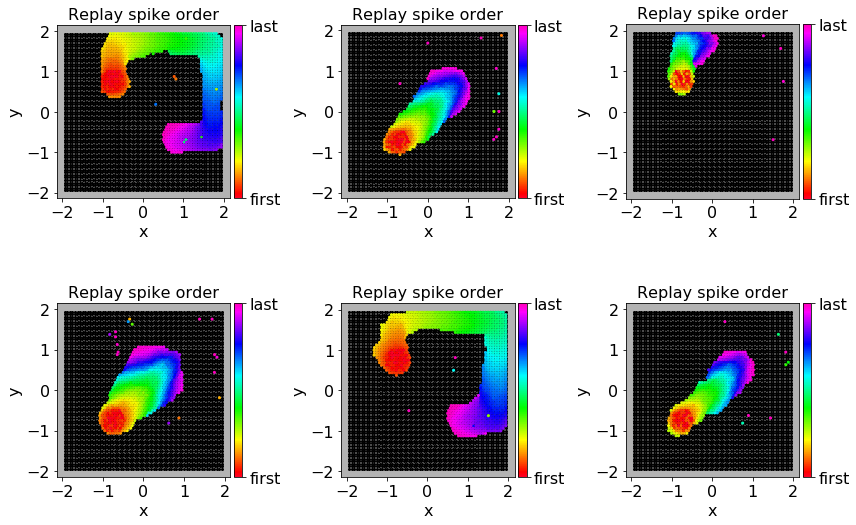

In [7]:
# plot results
sct_sz = 4
cmap = 'gist_rainbow'
shades = [(.68, .78), (.68, .97), (.68, .97), (.68, .8)]

for title, rslt, shade in zip(titles, rslts, shades):
    # get ntwk
    ntwk = rslt.ntwk
    mask_pc = ntwk.types_rcr == 'PC'
    pfxs_pc = ntwk.pfxs[mask_pc]
    pfys_pc = ntwk.pfys[mask_pc]
    
    
    # all replay epoch spk orders
    fig, axs = plt.subplots(2, 3, figsize=(12, 8), tight_layout=True)
    
    mask_pc = rslt.ntwk.types_rcr == 'PC'
    pfxs_pc = rslt.ntwk.pfxs[mask_pc]
    pfys_pc = rslt.ntwk.pfys[mask_pc]
    
    starts = [trg['T'] for trg in S['TRG']]
    wdws = 6 * [S['metrics']['WDW']]
    
    for start, wdw, ax in zip(starts, wdws, axs.flatten()):
        
        end = start + wdw
        
        t_mask = (start <= rslt.ts) & (rslt.ts < end)
        
        spks_wdw_pc = rslt.spks[t_mask][:, mask_pc]
        spk_ct_wdw_pc = spks_wdw_pc.sum(0)
        
        
        # PC spiking order
        if np.any(spk_ct_wdw_pc):

            ## black bkgd for all PCs
            ax.scatter(pfxs_pc, pfys_pc, c='k', s=sct_sz, zorder=-1)

            ## color PCs according to timing of first spike
            spk_mask = spk_ct_wdw_pc > 0
            spk_order = np.argmax(spks_wdw_pc[:, spk_mask], 0)
            spk_order = np.argsort(spk_order).argsort()

            v_min = spk_order.min()
            v_max = spk_order.max()

            im_1 = ax.scatter(
                pfxs_pc[spk_mask], pfys_pc[spk_mask], c=spk_order, s=sct_sz,
                vmin=v_min, vmax=v_max, cmap=cmap, zorder=0)

            divider_1 = make_axes_locatable(ax)
            c_ax_1 = divider_1.append_axes('right', size='5%', pad=0.05)

            cb_1 = fig.colorbar(im_1, cax=c_ax_1, ticks=[v_min, v_max])
            cb_1.set_ticklabels(['first', 'last'])

            ax.set_aspect('equal')

            set_n_x_ticks(ax, 5, -S['BOX_W']/2, S['BOX_W']/2)
            set_n_y_ticks(ax, 5, -S['BOX_H']/2, S['BOX_H']/2)

            ax.set_xlabel('X (m)')
            ax.set_ylabel('Y (m)')
            ax.set_title('Replay spike order')
            for ax_ in [ax, cb_1.ax]:
                set_font_size(ax_, 16)
        else:
            ax.set_title('No PC spks btwn {} and {}'.format(start, end))
            set_font_size(ax, 16)
            
        ax.set_facecolor((.7, .7, .7))

        ax.set_xlabel('x')
        ax.set_ylabel('y')